In [1]:
%%writefile large_batch_training.py

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import random_split
from google.colab import files

def compute_mean_std(dataset):
    """Compute the mean and std of CIFAR-100 dataset.

    Args:
        dataset: A dataset derived from `torch.utils.data.Dataset`,
                 such as `cifar100_training_dataset` or `cifar100_test_dataset`.

    Returns:
        A tuple containing (mean, std) for the entire dataset.
    """

    # Extract images and labels
    data_r = np.stack([np.array(dataset[i][0])[:, :, 0] for i in range(len(dataset))])
    data_g = np.stack([np.array(dataset[i][0])[:, :, 1] for i in range(len(dataset))])
    data_b = np.stack([np.array(dataset[i][0])[:, :, 2] for i in range(len(dataset))])

    # Compute mean and std
    mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
    std = np.std(data_r), np.std(data_g), np.std(data_b)

    return mean, std

# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(384, 192)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model
net = LeNet5().to(device)

# Optimizer Subclasses
class LARS(optim.Optimizer):
    def __init__(self, params, lr, momentum=0.9, weight_decay=0, trust_coefficient=0.001):
        # Initialize the optimizer with the learning rate, momentum, weight decay, and trust coefficient
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, trust_coefficient=trust_coefficient)
        super(LARS, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it (commonly used for re-evaluating loss)
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                   # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                if len(state) == 0:
                    state['momentum_buffer'] = torch.clone(grad).detach()
                # Apply weight decay directly to the gradient
                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])
                # Compute the norms of the parameter and its gradient
                param_norm = torch.norm(p.data)
                grad_norm = torch.norm(grad)
                # Compute local learning rate based on the trust coefficient and norms
                if param_norm > 0 and grad_norm > 0:
                    local_lr = group['trust_coefficient'] * param_norm / (grad_norm + 1e-8)
                    grad = grad.mul(local_lr) # Scale the gradient with the local learning rate
                # Update the momentum buffer
                momentum_buffer = state['momentum_buffer']
                momentum_buffer.mul_(group['momentum']).add_(grad) #Momentum update
                state['momentum_buffer'] = momentum_buffer
                # Update the parameter
                p.data.add_(-group['lr'], momentum_buffer) # Gradient descent step with learning rate
        return loss

class LAMB(optim.Optimizer):
    def __init__(self, params, lr, weight_decay=0, betas=(0.9, 0.999), eps=1e-8):
        # Initialize the optimizer with learning rate, weight decay, betas for moment updates, and epsilon for stability
        defaults = dict(lr=lr, weight_decay=weight_decay, betas=betas, eps=eps)
        super(LAMB, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                # Initialize state
                if len(state) == 0:
                    # Initialize the state (step counter, first moment, second moment)
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data) # First moment (mean of gradients)
                    state['exp_avg_sq'] = torch.zeros_like(p.data) # Second moment (mean of squared gradients)
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']
                beta1, beta2 = group['betas']  # Coefficients for moment updates
                state['step'] += 1 # Increment step count
                step = state['step']
                # Decay the first and second moment running average coefficients
                # Update first and second moments
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1) # Exponential moving average of gradients
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2) # Exponential moving average of squared gradients
                # Correct bias in the first and second moments
                bias_correction1 = 1 - beta1 ** step
                bias_correction2 = 1 - beta2 ** step
                corrected_exp_avg = exp_avg / bias_correction1
                corrected_exp_avg_sq = exp_avg_sq / bias_correction2
                # Compute the denominator for scaling the update
                denom = corrected_exp_avg_sq.sqrt().add_(group['eps']) # Stability epsilon
                # Compute the step update
                update = corrected_exp_avg / denom
                # Apply weight decay directly to the parameters
                if group['weight_decay'] != 0:
                    update.add_(p.data, alpha=group['weight_decay'])
                # Compute the trust ratio (norm of parameters vs norm of update)
                param_norm = torch.norm(p.data)
                update_norm = torch.norm(update)
                trust_ratio = 1.0  # Default trust ratio
                if param_norm > 0 and update_norm > 0:
                    trust_ratio = param_norm / update_norm
                # Update the parameters
                p.data.add_(-group['lr'] * trust_ratio, update)
        return loss

class SqrtLRScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, base_lr, batch_size, warmup_epochs, total_epochs, reference_batch_size, verbose=False):
        """
        Args:
            optimizer: PyTorch optimizer (e.g., Adam, LAMB, LARS).
            base_lr: Base learning rate for the reference batch size.
            batch_size: Current batch size.
            warmup_epochs: Number of warmup epochs.
            total_epochs: Total number of epochs.
            reference_batch_size: Batch size for which the base_lr is defined.
            verbose: Whether to print LR updates.
        """
        self.base_lr = base_lr
        self.batch_size = batch_size
        self.scaled_lr = base_lr * (batch_size / reference_batch_size) ** 0.5
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.verbose = verbose
        super(SqrtLRScheduler, self).__init__(optimizer)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            # Linear warmup scaling
            warmup_factor = (epoch + 1) / self.warmup_epochs
            return [warmup_factor * self.scaled_lr for _ in self.optimizer.param_groups]
        else:
            # polynomially decaying learning rate of ηt = η0×(1−t/T)
            if epoch == self.warmup_epochs:
                print(f"Warmup phase completed at epoch {epoch}. Switching to constant learning rate.")
            return [self.scaled_lr * ( 1 - ( (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs))) for _ in self.optimizer.param_groups]

# Command-line arguments
parser = argparse.ArgumentParser(description='Train with Large-Batch Optimizers')
parser.add_argument('--optimizer', type=str, default='SGDM', choices=['SGDM', 'AdamW', 'LARS', 'LAMB'],
                    help='Choose optimizer')
parser.add_argument('--batch-size', type=int, default=128, help='Batch size')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for SGDM and LARS')
parser.add_argument('--weight-decay', type=float, default=1e-5, help='Weight decay')
parser.add_argument('--b1', type=float, default=0.9, help='Beta1 for AdamW')
parser.add_argument('--b2', type=float, default=0.999, help='Beta2 for AdamW')
parser.add_argument('--trust-coefficient', type=float, default=0.001, help='Trust coefficient for LARS')
parser.add_argument('--epochs', type=int, default=150, help='Number of epochs')
parser.add_argument('--warmup-epochs', type=int, default=5, help='Number of epochs')
args = parser.parse_args()


torch.manual_seed(42) # Set the seed for reproducibility
torch.cuda.manual_seed_all(42) # Set the seed for reproducibility on GPU

# use the same mean and std to add consistency to all datasets
data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
mean, std = compute_mean_std(data)

# Load and split CIFAR-100 dataset
train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  # transforms.RandomRotation(15),
  transforms.RandomCrop(32, padding=4),
  # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
  transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.ToTensor(), # Convert into tensor
    transforms.Normalize(mean, std)  # Normalization
])

test_transform = transforms.Compose([
    transforms.CenterCrop(24),
    transforms.Pad(4),
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=val_transform)
indices = torch.randperm(len(trainset))
val_size = int(0.2*len(trainset))
trainset = torch.utils.data.Subset(trainset, indices[:-val_size])
valset = torch.utils.data.Subset(valset, indices[-val_size:])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=args.batch_size, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=2)


# Fixed parameter from paper [18] to calculate the square root LR scaling value
# base_lr = 5 / (2**3 * 10**3)
# reference_batch_size = 512
#scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5

# Mapping optimizers
if args.optimizer == 'SGDM':
    base_lr = 1e-2
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.SGD(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay)
elif args.optimizer == 'AdamW':
    base_lr = 5e-4
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.AdamW(net.parameters(), lr=scaled_lr, betas=(args.b1, args.b2), weight_decay=args.weight_decay)
elif args.optimizer == 'LARS':
    base_lr = 5 / (2**3 * 10**3) # to define
    reference_batch_size = 512
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LARS(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay, trust_coefficient=args.trust_coefficient)
elif args.optimizer == 'LAMB':
    base_lr = 5 / (2**3 * 10**3) # to define
    reference_batch_size = 512
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LAMB(net.parameters(), lr=scaled_lr, weight_decay=args.weight_decay)

criterion = nn.CrossEntropyLoss()

# scheduler should be e square root LR scaling rule and linear-epoch warmup scheduling to automatically adjust learning rate
scheduler = SqrtLRScheduler(
    optimizer = optimizer,
    base_lr = base_lr,
    batch_size = args.batch_size,
    warmup_epochs = args.warmup_epochs,
    total_epochs = args.epochs,
    reference_batch_size = reference_batch_size,
    verbose = True)

# Training Function
def train_model(optimizer, scheduler, model, criterion, trainloader, valloader , testloader, device, epochs, save_checkpoint_interval=10):
    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val, total_val, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()
        val_loss /= len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct_val / total_val
        val_accuracies.append(val_accuracy)

        '''
        # Early Stopping
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_no_improve = 0
        else:
          epochs_no_improve += 1

        if epochs_no_improve == patience:
          print("Early stopping!")
          break
        '''

        # Test
        correct_test, total_test, test_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()
        test_loss /= len(testloader)
        test_losses.append(test_loss)
        test_accuracy = 100. * correct_test / total_test
        test_accuracies.append(test_accuracy)

        scheduler.step()

        # Checkpointing
        if (epoch + 1) % save_checkpoint_interval == 0:
            checkpoint_filename = f'checkpoint_epoch_{epoch + 1}.pth'
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': loss.item(),
            }
            checkpoint_path = os.path.join('./', checkpoint_filename)
            torch.save(checkpoint, checkpoint_path)
            print(f'Checkpoint saved at epoch {epoch + 1}: {checkpoint_path}')

            # Download the checkpoint
            files.download(checkpoint_filename)

        print(f'Epoch {epoch+1}/{epochs}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

# Train the model
print(f"--- Train with {args.optimizer} ---")
train_loss, val_loss, test_loss, train_acc, val_acc, test_acc = train_model(optimizer, scheduler, net, criterion, trainloader, valloader, testloader, device, args.epochs)

# Save model
torch.save(net.state_dict(), f'net_{args.optimizer}.pth')

# Plot results
# Plot Training Loss
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('train_loss.png')
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(6, 4))
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('train_accuracy.png')
plt.show()

# Plot Validation Loss
plt.figure(figsize=(6, 4))
plt.plot(val_loss, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('val_loss.png')
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(6, 4))
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('val_accuracy.png')
plt.show()

# Plot Test Loss
plt.figure(figsize=(6, 4))
plt.plot(test_loss, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('test_loss.png')
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(6, 4))
plt.plot(test_acc, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('test_accuracy.png')
plt.show()


Writing large_batch_training.py


In [ ]:
%run large_batch_training.py --optimizer SGDM --batch-size 128 --weight-decay 4e-4

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
--- Train with SGDM ---


KeyboardInterrupt: 

100%|██████████| 169M/169M [00:12<00:00, 13.2MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
--- Train with AdamW ---
Epoch 1/150, Train Acc: 3.35%, Val Acc: 7.22%, Test Acc: 5.89%
Epoch 1/150, Train Loss: 4.4323, Val Loss: 4.1276, Test Loss: 4.1515
Epoch 2/150, Train Acc: 7.51%, Val Acc: 11.72%, Test Acc: 10.62%
Epoch 2/150, Train Loss: 4.1268, Val Loss: 3.8674, Test Loss: 3.9243
Epoch 3/150, Train Acc: 10.70%, Val Acc: 13.86%, Test Acc: 12.53%
Epoch 3/150, Train Loss: 3.9042, Val Loss: 3.7104, Test Loss: 3.7681
Epoch 4/150, Train Acc: 13.30%, Val Acc: 17.39%, Test Acc: 15.34%
Epoch 4/150, Train Loss: 3.7246, Val Loss: 3.4986, Test Loss: 3.5817
Warmup phase completed at epoch 5. Switching to constant learning rate.
Epoch 5/150, Train Acc: 15.39%, Val Acc: 19.12%, Test Acc: 16.38%
Epoch 5/150, Train Loss: 3.5732, Val Loss: 3.3942, Test Loss: 3.5413
Epoch 6/150, Train Acc: 17.87%, Val Acc: 19.77%, Test Acc: 17.87%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 10/150, Train Acc: 25.12%, Val Acc: 28.28%, Test Acc: 23.14%
Epoch 10/150, Train Loss: 3.0352, Val Loss: 2.9376, Test Loss: 3.2221
Epoch 11/150, Train Acc: 26.83%, Val Acc: 29.63%, Test Acc: 24.79%
Epoch 11/150, Train Loss: 2.9465, Val Loss: 2.8108, Test Loss: 3.1307
Epoch 12/150, Train Acc: 27.89%, Val Acc: 31.95%, Test Acc: 27.91%
Epoch 12/150, Train Loss: 2.8845, Val Loss: 2.7048, Test Loss: 2.9345
Epoch 13/150, Train Acc: 29.30%, Val Acc: 33.13%, Test Acc: 26.48%
Epoch 13/150, Train Loss: 2.8179, Val Loss: 2.6583, Test Loss: 2.9723
Epoch 14/150, Train Acc: 29.78%, Val Acc: 34.16%, Test Acc: 30.00%
Epoch 14/150, Train Loss: 2.7914, Val Loss: 2.6051, Test Loss: 2.7902
Epoch 15/150, Train Acc: 30.79%, Val Acc: 34.11%, Test Acc: 29.38%
Epoch 15/150, Train Loss: 2.7490, Val Loss: 2.5917, Test Loss: 2.8620
Epoch 16/150, Train Acc: 31.94%, Val Acc: 34.61%, Test Acc: 30.72%
Epoch 16/150, Train Loss: 2.7000, Val Loss: 2.5823, Test Loss: 2.7822
Epoch 17/150, Train Acc: 32.36%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 20/150, Train Acc: 34.31%, Val Acc: 35.77%, Test Acc: 32.61%
Epoch 20/150, Train Loss: 2.5719, Val Loss: 2.4964, Test Loss: 2.7242
Epoch 21/150, Train Acc: 35.30%, Val Acc: 38.13%, Test Acc: 33.91%
Epoch 21/150, Train Loss: 2.5136, Val Loss: 2.4219, Test Loss: 2.6349
Epoch 22/150, Train Acc: 35.81%, Val Acc: 38.01%, Test Acc: 33.79%
Epoch 22/150, Train Loss: 2.4850, Val Loss: 2.4226, Test Loss: 2.6316
Epoch 23/150, Train Acc: 36.32%, Val Acc: 37.77%, Test Acc: 33.72%
Epoch 23/150, Train Loss: 2.4695, Val Loss: 2.4398, Test Loss: 2.6220
Epoch 24/150, Train Acc: 37.59%, Val Acc: 38.97%, Test Acc: 33.26%
Epoch 24/150, Train Loss: 2.4211, Val Loss: 2.3788, Test Loss: 2.6763
Epoch 25/150, Train Acc: 38.10%, Val Acc: 37.88%, Test Acc: 32.02%
Epoch 25/150, Train Loss: 2.3974, Val Loss: 2.4637, Test Loss: 2.7474
Epoch 26/150, Train Acc: 37.41%, Val Acc: 39.98%, Test Acc: 33.56%
Epoch 26/150, Train Loss: 2.4345, Val Loss: 2.3574, Test Loss: 2.6843
Epoch 27/150, Train Acc: 39.11%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 30/150, Train Acc: 40.44%, Val Acc: 40.98%, Test Acc: 37.00%
Epoch 30/150, Train Loss: 2.2923, Val Loss: 2.2969, Test Loss: 2.5003
Epoch 31/150, Train Acc: 40.66%, Val Acc: 40.00%, Test Acc: 35.80%
Epoch 31/150, Train Loss: 2.2594, Val Loss: 2.3622, Test Loss: 2.5540
Epoch 32/150, Train Acc: 40.76%, Val Acc: 41.28%, Test Acc: 36.65%
Epoch 32/150, Train Loss: 2.2591, Val Loss: 2.2904, Test Loss: 2.5235
Epoch 33/150, Train Acc: 41.12%, Val Acc: 41.82%, Test Acc: 36.04%
Epoch 33/150, Train Loss: 2.2452, Val Loss: 2.2660, Test Loss: 2.5559
Epoch 34/150, Train Acc: 41.84%, Val Acc: 41.28%, Test Acc: 36.02%
Epoch 34/150, Train Loss: 2.2205, Val Loss: 2.2806, Test Loss: 2.5224
Epoch 35/150, Train Acc: 42.03%, Val Acc: 42.25%, Test Acc: 36.98%
Epoch 35/150, Train Loss: 2.1960, Val Loss: 2.2745, Test Loss: 2.5491
Epoch 36/150, Train Acc: 42.71%, Val Acc: 42.78%, Test Acc: 38.56%
Epoch 36/150, Train Loss: 2.1711, Val Loss: 2.2330, Test Loss: 2.4405
Epoch 37/150, Train Acc: 42.69%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 40/150, Train Acc: 43.59%, Val Acc: 42.48%, Test Acc: 36.34%
Epoch 40/150, Train Loss: 2.1258, Val Loss: 2.2404, Test Loss: 2.5826
Epoch 41/150, Train Acc: 43.91%, Val Acc: 42.30%, Test Acc: 37.36%
Epoch 41/150, Train Loss: 2.1198, Val Loss: 2.2766, Test Loss: 2.5304
Epoch 42/150, Train Acc: 44.16%, Val Acc: 43.50%, Test Acc: 38.26%
Epoch 42/150, Train Loss: 2.1026, Val Loss: 2.2337, Test Loss: 2.4660
Epoch 43/150, Train Acc: 44.96%, Val Acc: 42.64%, Test Acc: 34.45%
Epoch 43/150, Train Loss: 2.0656, Val Loss: 2.2862, Test Loss: 2.7418
Epoch 44/150, Train Acc: 44.33%, Val Acc: 43.42%, Test Acc: 38.50%
Epoch 44/150, Train Loss: 2.0911, Val Loss: 2.2091, Test Loss: 2.4458
Epoch 45/150, Train Acc: 45.15%, Val Acc: 43.56%, Test Acc: 38.49%
Epoch 45/150, Train Loss: 2.0687, Val Loss: 2.2410, Test Loss: 2.5048
Epoch 46/150, Train Acc: 45.45%, Val Acc: 43.91%, Test Acc: 38.18%
Epoch 46/150, Train Loss: 2.0474, Val Loss: 2.1680, Test Loss: 2.4791
Epoch 47/150, Train Acc: 45.96%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 50/150, Train Acc: 46.59%, Val Acc: 44.79%, Test Acc: 38.31%
Epoch 50/150, Train Loss: 2.0052, Val Loss: 2.1975, Test Loss: 2.5166
Epoch 51/150, Train Acc: 46.99%, Val Acc: 44.64%, Test Acc: 37.62%
Epoch 51/150, Train Loss: 1.9754, Val Loss: 2.1780, Test Loss: 2.5653
Epoch 52/150, Train Acc: 46.86%, Val Acc: 44.48%, Test Acc: 36.31%
Epoch 52/150, Train Loss: 1.9702, Val Loss: 2.1932, Test Loss: 2.5908
Epoch 53/150, Train Acc: 47.46%, Val Acc: 44.56%, Test Acc: 37.71%
Epoch 53/150, Train Loss: 1.9494, Val Loss: 2.1608, Test Loss: 2.4779
Epoch 54/150, Train Acc: 47.59%, Val Acc: 45.47%, Test Acc: 39.63%
Epoch 54/150, Train Loss: 1.9638, Val Loss: 2.1439, Test Loss: 2.4068
Epoch 55/150, Train Acc: 48.03%, Val Acc: 45.56%, Test Acc: 39.30%
Epoch 55/150, Train Loss: 1.9298, Val Loss: 2.1319, Test Loss: 2.4368
Epoch 56/150, Train Acc: 48.24%, Val Acc: 44.62%, Test Acc: 39.21%
Epoch 56/150, Train Loss: 1.9173, Val Loss: 2.1780, Test Loss: 2.4672
Epoch 57/150, Train Acc: 48.36%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 60/150, Train Acc: 48.68%, Val Acc: 45.60%, Test Acc: 40.00%
Epoch 60/150, Train Loss: 1.8880, Val Loss: 2.1384, Test Loss: 2.4080
Epoch 61/150, Train Acc: 49.37%, Val Acc: 45.92%, Test Acc: 39.84%
Epoch 61/150, Train Loss: 1.8872, Val Loss: 2.1237, Test Loss: 2.4442
Epoch 62/150, Train Acc: 49.91%, Val Acc: 46.24%, Test Acc: 40.31%
Epoch 62/150, Train Loss: 1.8507, Val Loss: 2.1087, Test Loss: 2.4166
Epoch 63/150, Train Acc: 49.92%, Val Acc: 46.58%, Test Acc: 40.08%
Epoch 63/150, Train Loss: 1.8542, Val Loss: 2.0965, Test Loss: 2.4220
Epoch 64/150, Train Acc: 49.92%, Val Acc: 45.82%, Test Acc: 40.62%
Epoch 64/150, Train Loss: 1.8453, Val Loss: 2.1458, Test Loss: 2.3816
Epoch 65/150, Train Acc: 50.15%, Val Acc: 46.05%, Test Acc: 39.70%
Epoch 65/150, Train Loss: 1.8330, Val Loss: 2.1697, Test Loss: 2.4441
Epoch 66/150, Train Acc: 49.76%, Val Acc: 46.74%, Test Acc: 41.64%
Epoch 66/150, Train Loss: 1.8373, Val Loss: 2.1243, Test Loss: 2.3504
Epoch 67/150, Train Acc: 50.65%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 70/150, Train Acc: 51.10%, Val Acc: 47.40%, Test Acc: 41.40%
Epoch 70/150, Train Loss: 1.7994, Val Loss: 2.1063, Test Loss: 2.3898
Epoch 71/150, Train Acc: 51.35%, Val Acc: 46.07%, Test Acc: 40.99%
Epoch 71/150, Train Loss: 1.7944, Val Loss: 2.1145, Test Loss: 2.3634
Epoch 72/150, Train Acc: 51.26%, Val Acc: 46.84%, Test Acc: 41.12%
Epoch 72/150, Train Loss: 1.7834, Val Loss: 2.0919, Test Loss: 2.3994
Epoch 73/150, Train Acc: 51.75%, Val Acc: 46.52%, Test Acc: 40.90%
Epoch 73/150, Train Loss: 1.7730, Val Loss: 2.1229, Test Loss: 2.4282
Epoch 74/150, Train Acc: 51.87%, Val Acc: 47.12%, Test Acc: 41.82%
Epoch 74/150, Train Loss: 1.7628, Val Loss: 2.1025, Test Loss: 2.3412
Epoch 75/150, Train Acc: 52.31%, Val Acc: 47.15%, Test Acc: 40.69%
Epoch 75/150, Train Loss: 1.7436, Val Loss: 2.0929, Test Loss: 2.3927
Epoch 76/150, Train Acc: 52.51%, Val Acc: 46.27%, Test Acc: 40.84%
Epoch 76/150, Train Loss: 1.7354, Val Loss: 2.1389, Test Loss: 2.3877
Epoch 77/150, Train Acc: 52.03%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 80/150, Train Acc: 52.07%, Val Acc: 47.56%, Test Acc: 41.09%
Epoch 80/150, Train Loss: 1.7479, Val Loss: 2.0868, Test Loss: 2.3801
Epoch 81/150, Train Acc: 52.67%, Val Acc: 48.03%, Test Acc: 41.19%
Epoch 81/150, Train Loss: 1.7310, Val Loss: 2.0885, Test Loss: 2.3947
Epoch 82/150, Train Acc: 52.81%, Val Acc: 46.91%, Test Acc: 39.83%
Epoch 82/150, Train Loss: 1.7162, Val Loss: 2.1370, Test Loss: 2.5013
Epoch 83/150, Train Acc: 53.34%, Val Acc: 48.03%, Test Acc: 41.98%
Epoch 83/150, Train Loss: 1.7066, Val Loss: 2.0909, Test Loss: 2.3553
Epoch 84/150, Train Acc: 53.09%, Val Acc: 47.32%, Test Acc: 40.90%
Epoch 84/150, Train Loss: 1.6987, Val Loss: 2.1126, Test Loss: 2.4191
Epoch 85/150, Train Acc: 53.55%, Val Acc: 47.19%, Test Acc: 41.23%
Epoch 85/150, Train Loss: 1.6948, Val Loss: 2.0996, Test Loss: 2.3616
Epoch 86/150, Train Acc: 53.67%, Val Acc: 47.62%, Test Acc: 41.76%
Epoch 86/150, Train Loss: 1.6770, Val Loss: 2.0945, Test Loss: 2.3867
Epoch 87/150, Train Acc: 53.52%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 90/150, Train Acc: 54.52%, Val Acc: 47.95%, Test Acc: 42.41%
Epoch 90/150, Train Loss: 1.6436, Val Loss: 2.0832, Test Loss: 2.3592
Epoch 91/150, Train Acc: 54.83%, Val Acc: 46.96%, Test Acc: 41.51%
Epoch 91/150, Train Loss: 1.6304, Val Loss: 2.1144, Test Loss: 2.3703
Epoch 92/150, Train Acc: 54.83%, Val Acc: 47.63%, Test Acc: 41.96%
Epoch 92/150, Train Loss: 1.6346, Val Loss: 2.1050, Test Loss: 2.3892
Epoch 93/150, Train Acc: 54.61%, Val Acc: 48.09%, Test Acc: 41.63%
Epoch 93/150, Train Loss: 1.6475, Val Loss: 2.0928, Test Loss: 2.3931
Epoch 94/150, Train Acc: 54.99%, Val Acc: 48.04%, Test Acc: 41.97%
Epoch 94/150, Train Loss: 1.6299, Val Loss: 2.0911, Test Loss: 2.3931
Epoch 95/150, Train Acc: 55.19%, Val Acc: 47.42%, Test Acc: 40.64%
Epoch 95/150, Train Loss: 1.6190, Val Loss: 2.1132, Test Loss: 2.4437
Epoch 96/150, Train Acc: 55.60%, Val Acc: 48.02%, Test Acc: 41.95%
Epoch 96/150, Train Loss: 1.6071, Val Loss: 2.0920, Test Loss: 2.3838
Epoch 97/150, Train Acc: 55.37%, Val Acc:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 100/150, Train Acc: 56.01%, Val Acc: 48.18%, Test Acc: 42.26%
Epoch 100/150, Train Loss: 1.5938, Val Loss: 2.1189, Test Loss: 2.4045
Epoch 101/150, Train Acc: 55.74%, Val Acc: 48.43%, Test Acc: 42.30%
Epoch 101/150, Train Loss: 1.5956, Val Loss: 2.0736, Test Loss: 2.3591
Epoch 102/150, Train Acc: 56.11%, Val Acc: 48.52%, Test Acc: 42.21%
Epoch 102/150, Train Loss: 1.5822, Val Loss: 2.0786, Test Loss: 2.3661
Epoch 103/150, Train Acc: 56.89%, Val Acc: 48.33%, Test Acc: 42.62%
Epoch 103/150, Train Loss: 1.5569, Val Loss: 2.0866, Test Loss: 2.3627
Epoch 104/150, Train Acc: 56.37%, Val Acc: 47.79%, Test Acc: 41.83%
Epoch 104/150, Train Loss: 1.5545, Val Loss: 2.1411, Test Loss: 2.4247
Epoch 105/150, Train Acc: 56.59%, Val Acc: 48.64%, Test Acc: 42.55%
Epoch 105/150, Train Loss: 1.5559, Val Loss: 2.0808, Test Loss: 2.3631
Epoch 106/150, Train Acc: 57.00%, Val Acc: 49.07%, Test Acc: 43.45%
Epoch 106/150, Train Loss: 1.5523, Val Loss: 2.0741, Test Loss: 2.3231
Epoch 107/150, Train Acc: 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 110/150, Train Acc: 57.11%, Val Acc: 48.84%, Test Acc: 43.16%
Epoch 110/150, Train Loss: 1.5517, Val Loss: 2.0935, Test Loss: 2.3642
Epoch 111/150, Train Acc: 57.18%, Val Acc: 48.99%, Test Acc: 43.32%
Epoch 111/150, Train Loss: 1.5381, Val Loss: 2.0748, Test Loss: 2.3418
Epoch 112/150, Train Acc: 57.81%, Val Acc: 48.47%, Test Acc: 42.25%
Epoch 112/150, Train Loss: 1.5188, Val Loss: 2.1050, Test Loss: 2.3913
Epoch 113/150, Train Acc: 57.30%, Val Acc: 48.96%, Test Acc: 42.58%
Epoch 113/150, Train Loss: 1.5318, Val Loss: 2.0775, Test Loss: 2.3813
Epoch 114/150, Train Acc: 57.96%, Val Acc: 49.30%, Test Acc: 43.23%
Epoch 114/150, Train Loss: 1.5137, Val Loss: 2.0680, Test Loss: 2.3295
Epoch 115/150, Train Acc: 58.12%, Val Acc: 48.63%, Test Acc: 43.00%
Epoch 115/150, Train Loss: 1.4985, Val Loss: 2.0828, Test Loss: 2.3581
Epoch 116/150, Train Acc: 58.30%, Val Acc: 48.34%, Test Acc: 43.11%
Epoch 116/150, Train Loss: 1.5037, Val Loss: 2.1025, Test Loss: 2.3634
Epoch 117/150, Train Acc: 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 120/150, Train Acc: 58.59%, Val Acc: 49.37%, Test Acc: 43.90%
Epoch 120/150, Train Loss: 1.4865, Val Loss: 2.1007, Test Loss: 2.3399
Epoch 121/150, Train Acc: 58.84%, Val Acc: 49.46%, Test Acc: 42.89%
Epoch 121/150, Train Loss: 1.4755, Val Loss: 2.0742, Test Loss: 2.3635
Epoch 122/150, Train Acc: 58.49%, Val Acc: 49.33%, Test Acc: 43.39%
Epoch 122/150, Train Loss: 1.4612, Val Loss: 2.0799, Test Loss: 2.3362
Epoch 123/150, Train Acc: 59.02%, Val Acc: 49.54%, Test Acc: 43.42%
Epoch 123/150, Train Loss: 1.4618, Val Loss: 2.0664, Test Loss: 2.3751
Epoch 124/150, Train Acc: 58.90%, Val Acc: 49.65%, Test Acc: 43.26%
Epoch 124/150, Train Loss: 1.4514, Val Loss: 2.0841, Test Loss: 2.3916
Epoch 125/150, Train Acc: 59.28%, Val Acc: 49.95%, Test Acc: 43.92%
Epoch 125/150, Train Loss: 1.4452, Val Loss: 2.0649, Test Loss: 2.3303
Epoch 126/150, Train Acc: 59.58%, Val Acc: 49.15%, Test Acc: 43.87%
Epoch 126/150, Train Loss: 1.4499, Val Loss: 2.0614, Test Loss: 2.3327
Epoch 127/150, Train Acc: 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 130/150, Train Acc: 59.55%, Val Acc: 49.51%, Test Acc: 44.12%
Epoch 130/150, Train Loss: 1.4366, Val Loss: 2.0705, Test Loss: 2.3468
Epoch 131/150, Train Acc: 59.76%, Val Acc: 49.65%, Test Acc: 43.77%
Epoch 131/150, Train Loss: 1.4369, Val Loss: 2.0727, Test Loss: 2.3472
Epoch 132/150, Train Acc: 59.82%, Val Acc: 49.96%, Test Acc: 43.70%
Epoch 132/150, Train Loss: 1.4244, Val Loss: 2.0813, Test Loss: 2.3662
Epoch 133/150, Train Acc: 60.20%, Val Acc: 49.70%, Test Acc: 43.30%
Epoch 133/150, Train Loss: 1.4205, Val Loss: 2.0909, Test Loss: 2.3787
Epoch 134/150, Train Acc: 60.01%, Val Acc: 49.89%, Test Acc: 43.35%
Epoch 134/150, Train Loss: 1.4175, Val Loss: 2.0774, Test Loss: 2.3575
Epoch 135/150, Train Acc: 60.08%, Val Acc: 49.99%, Test Acc: 43.72%
Epoch 135/150, Train Loss: 1.4072, Val Loss: 2.0756, Test Loss: 2.3488
Epoch 136/150, Train Acc: 60.81%, Val Acc: 49.57%, Test Acc: 43.95%
Epoch 136/150, Train Loss: 1.3991, Val Loss: 2.0780, Test Loss: 2.3298
Epoch 137/150, Train Acc: 6

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 140/150, Train Acc: 60.74%, Val Acc: 50.37%, Test Acc: 43.67%
Epoch 140/150, Train Loss: 1.3952, Val Loss: 2.0733, Test Loss: 2.3715
Epoch 141/150, Train Acc: 61.07%, Val Acc: 49.84%, Test Acc: 44.02%
Epoch 141/150, Train Loss: 1.3889, Val Loss: 2.0705, Test Loss: 2.3328
Epoch 142/150, Train Acc: 60.90%, Val Acc: 50.24%, Test Acc: 43.86%
Epoch 142/150, Train Loss: 1.3838, Val Loss: 2.0741, Test Loss: 2.3635
Epoch 143/150, Train Acc: 60.87%, Val Acc: 50.12%, Test Acc: 43.92%
Epoch 143/150, Train Loss: 1.3967, Val Loss: 2.0690, Test Loss: 2.3480
Epoch 144/150, Train Acc: 60.93%, Val Acc: 50.46%, Test Acc: 43.74%
Epoch 144/150, Train Loss: 1.3787, Val Loss: 2.0654, Test Loss: 2.3462
Epoch 145/150, Train Acc: 61.18%, Val Acc: 50.34%, Test Acc: 43.85%
Epoch 145/150, Train Loss: 1.3813, Val Loss: 2.0732, Test Loss: 2.3625
Epoch 146/150, Train Acc: 61.08%, Val Acc: 50.33%, Test Acc: 43.78%
Epoch 146/150, Train Loss: 1.3815, Val Loss: 2.0664, Test Loss: 2.3568
Epoch 147/150, Train Acc: 6

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 150/150, Train Acc: 61.58%, Val Acc: 50.32%, Test Acc: 43.88%
Epoch 150/150, Train Loss: 1.3534, Val Loss: 2.0608, Test Loss: 2.3448


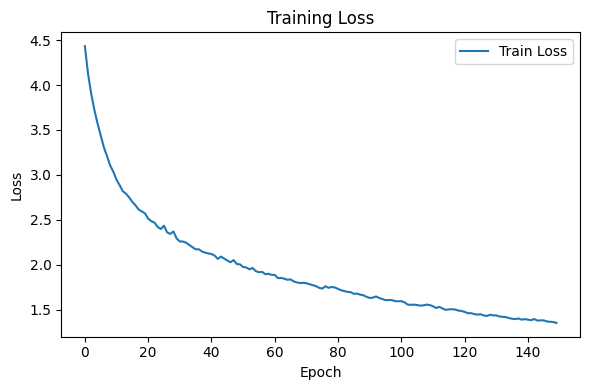

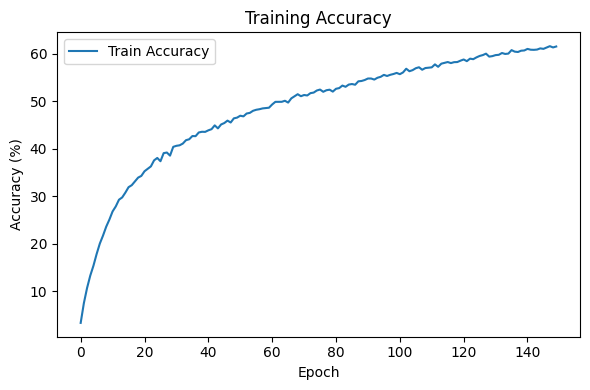

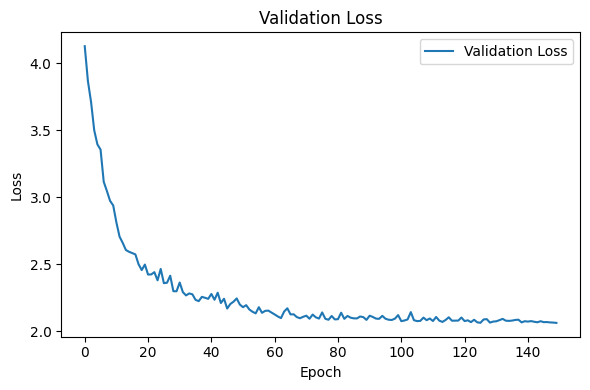

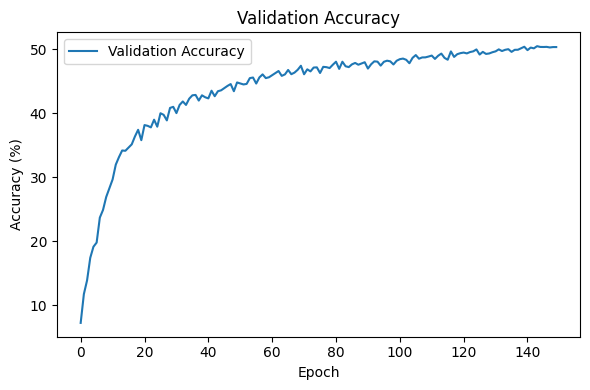

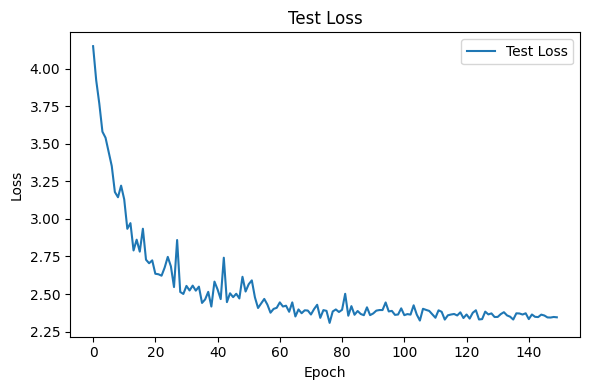

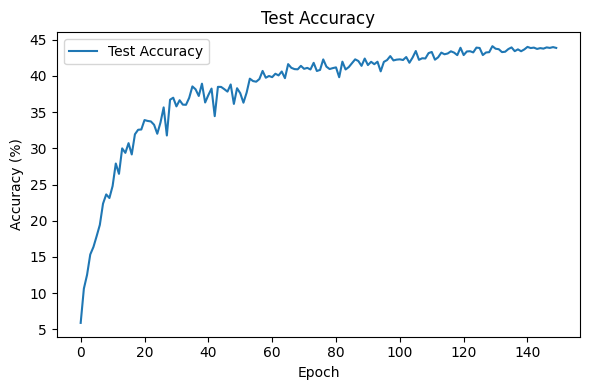

<Figure size 640x480 with 0 Axes>

In [2]:
%run large_batch_training.py --optimizer AdamW --batch-size 1024 --weight-decay 1e-2

In [ ]:
%run large_batch_training.py --optimizer LARS --batch-size 128 --weight-decay 4e-4

Files already downloaded and verified
Files already downloaded and verified
--- Train with LARS ---


In [ ]:
%run large_batch_training.py --optimizer LAMB --batch-size 128 --weight-decay 1e-2

Files already downloaded and verified
Files already downloaded and verified
--- Train with LAMB ---
